## Grafo RDF utilizando RDFLib (Python)

Este notebook contém um exemplo de construção de uma ontologia a partir do banco de dados relacional disponível [neste link](https://www.w3.org/TR/r2rml/#example-input-database), incluindo:
- Como popular um grafo RDF
- Realizar serialização em Python usando `rdflib`
- Visualizar o grafo (NetworkX/Matplotlib, PyVis).

> O repositório GitHub com o material da aula pode ser acessado [neste link](https://github.com/BernardoCaixeta/Ontologia-SPARQL)

> Execute as células na ordem. Se estiver em um ambiente novo, execute primeiro a **instalação** das dependências.


In [ ]:
from rdflib import Graph, Namespace, URIRef, Literal, RDFS
from rdflib.namespace import RDF, XSD
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

- Cria um grafo `rdflib.Graph()` que armazenará triplas RDF.

In [2]:
g = Graph()

- Define o namespace base `ex:` (ex.: `http://example.org/`) e faz `bind` para facilitar a leitura nas consultas/serializações.

In [3]:
EX = Namespace("http://example.org/")
g.bind("ex", EX)

- Definição de recurso (instância) -> `Departamento 10`

In [4]:
dept_10 = EX["dept/10"]

g.add((dept_10, RDF.type, EX.Department))
g.add((dept_10, EX.deptno, Literal(10, datatype=XSD.integer)))
g.add((dept_10, EX.dname, Literal("APPSERVER")))
g.add((dept_10, EX.loc,   Literal("NEW YORK")))

<Graph identifier=Nbcad8a6466c24bc0b5439ad0df481b8b (<class 'rdflib.graph.Graph'>)>

- Definição de recurso (instância) -> `Empregado 7369`

In [5]:
emp_7369 = EX["emp/7369"]

g.add((emp_7369, RDF.type, EX.Employee))
g.add((emp_7369, EX.empno, Literal(7369, datatype=XSD.integer)))
g.add((emp_7369, EX.ename, Literal("SMITH")))
g.add((emp_7369, EX.job,   Literal("CLERK")))

<Graph identifier=Nbcad8a6466c24bc0b5439ad0df481b8b (<class 'rdflib.graph.Graph'>)>

- Definição da relação entre `Empregado 7369` e `Departamento 10` através do predicado `worksIn`

In [6]:
g.add((emp_7369, EX.worksIn, dept_10))

<Graph identifier=Nbcad8a6466c24bc0b5439ad0df481b8b (<class 'rdflib.graph.Graph'>)>

- Mostra o grafo em formato `Turtle`

In [7]:
print(g.serialize(format="turtle"))

@prefix ex: <http://example.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/emp/7369> a ex:Employee ;
    ex:empno 7369 ;
    ex:ename "SMITH" ;
    ex:job "CLERK" ;
    ex:worksIn <http://example.org/dept/10> .

<http://example.org/dept/10> a ex:Department ;
    ex:deptno 10 ;
    ex:dname "APPSERVER" ;
    ex:loc "NEW YORK" .




### Visualização estática do grafo (NetworkX + Matplotlib)

- Constrói um grafo dirigido/multiaresta a partir de triplas.
- Desenha nós e rótulos; exibe labels de arestas (predicados).

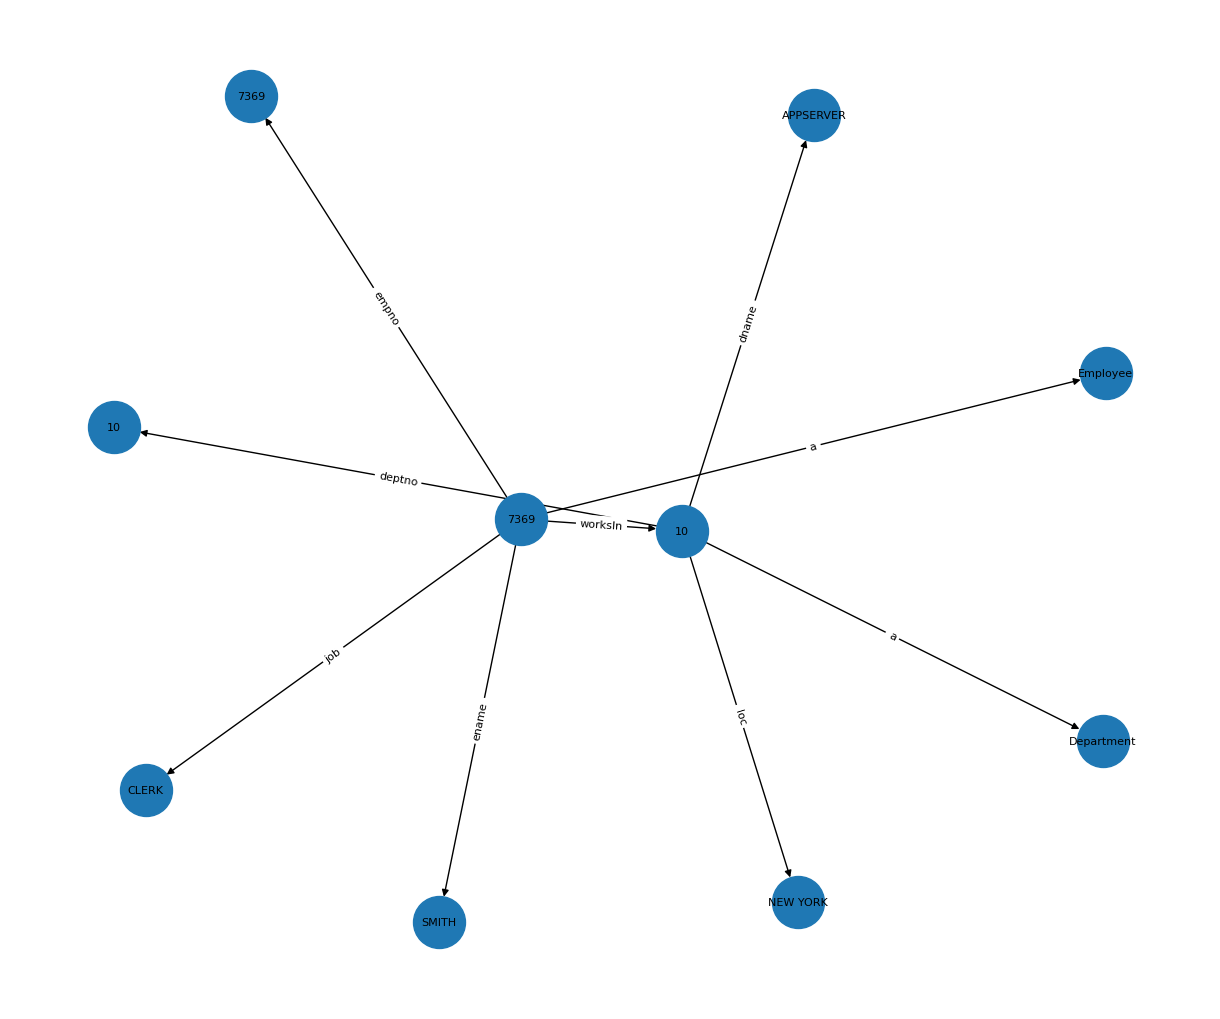

In [8]:
def short(u):
    s = str(u)
    if "#" in s: return s.split("#")[-1]
    if "/" in s: return s.rstrip("/").split("/")[-1]
    return s

def label_for(u):
    lbl = next(g.objects(u, RDFS.label), None)
    return str(lbl) if lbl else short(u)

def in_ex(u): return str(u).startswith(str(EX))

G = nx.MultiDiGraph()
for s,p,o in g.triples((None,None,None)):
    if o.__class__.__name__ == "Literal":
        o_node = f'"{o}"'
        G.add_node(o_node, label=str(o))
        G.add_edge(s, o_node, label=short(p))
    else:
        if in_ex(s) and in_ex(o):
            G.add_node(s, label=label_for(s))
            G.add_node(o, label=label_for(o))
            edge_label = "a" if p == RDF.type else short(p)
            G.add_edge(s, o, label=edge_label)
            
pos = nx.spring_layout(G, seed=42)
node_labels = {n: G.nodes[n].get("label", short(n)) for n in G.nodes()}
edge_labels = {(u,v,k): d.get("label","") for u,v,k,d in G.edges(keys=True, data=True)}

plt.figure(figsize=(12,10))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1400, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.savefig("2.1 - grafo_estatico.png")
plt.show()

### Visualização interativa do grafo (pyviz)

- Constrói um grafo dirigido/multiaresta a partir de triplas.
- Desenha nós e rótulos; exibe labels de arestas (predicados).

In [9]:
net = Network(height="800px", width="100%", notebook=True, directed=True, select_menu=True)

nodes = set()
for (s, p, o) in g.triples((None, None, None)):
    nodes.add(s)
    nodes.add(o)

for n in nodes:
    if isinstance(n, Literal):
        net.add_node(
            str(n),
            label=str(n),
            shape="box",
            title=f"Literal ({type(n.value).__name__})"
        )
    else:
        net.add_node(
            str(n),
            label=label_for(n),
            shape="ellipse",
            title=str(n)
        )

for (s, p, o) in g.triples((None, None, None)):
    lab = "a" if str(p).endswith("type") else p.split("#")[-1].split("/")[-1]
    net.add_edge(str(s), str(o), label=lab)

net.show("2.1 - grafo_interativo.html", notebook=False)

2.1 - grafo_interativo.html
